In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import gc

In [2]:
from modeling.segment_anything.utils.transforms import ResizeLongestSide
from modeling.segment_anything import prepare_sam
from config import cfg  # Import the default config file
import torch
import torch.nn.functional as F
from torch.nn.functional import threshold, normalize
import cv2
from modeling.segment_anything.automatic_mask_generator import SamAutomaticMaskGenerator

In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    del mask
    gc.collect()

def show_masks_on_image(raw_image, masks):
  plt.imshow(np.array(raw_image))
  ax = plt.gca()
  ax.set_autoscale_on(False)
  for mask in masks:
      show_mask(mask, ax=ax, random_color=True)
  plt.axis("off")
  plt.show()
  del mask
  gc.collect()

In [4]:
#Read image using PIL
image = Image.open('4389.png')

In [5]:
cfg.freeze()
print(cfg)

BBOX:
  BOX_LIMITER: 50
  MIN_DISTANCE: 50
  NUMBER: 30
  SIZE_REF: 0.25
DATALOADER:
  NUM_WORKERS: 8
  TRAIN_DATA: 0.8
  VALID_DATA: 0.2
DATASETS:
  ROOT_DIR: /home/aghosh57/Kerner-Lab/all_dataset/
INPUT:
  
LOGGER:
  LEVEL: DEBUG
LOSS:
  DICE_LOSS_WEIGHT: 1
  FOCAL_LOSS_WEIGHT: 1
MASKS:
  MIN_AREA: 1000
MODEL:
  CHECKPOINT: /home/aghosh57/Kerner-Lab/SAM-FineTuning/logs/Jun28_21-40-50/model_checkpoints/sam_checkpoint_final.pth
  DEVICE: cuda
  SAVE_INTERVAL: 1
  TYPE: base
OUTPUT_DIR: ./logs/
SOLVER:
  ITEMS_PER_BATCH: 16
  MAX_EPOCHS: 1
  MIN_LR: 1e-06
  MOMENTUM: 0.9
  START_LR: 0.01
  WEIGHT_DECAY: 0.0001
TEST:
  ITEMS_PER_BATCH: 1
VALID:
  ITEMS_PER_BATCH: 4


In [6]:
# Get the model and download the checkpoint if needed
model = prepare_sam(checkpoint=cfg.MODEL.CHECKPOINT, model_type = cfg.MODEL.TYPE)
device = cfg.MODEL.DEVICE
model.to(device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


Automatic Method of Generating the Masks

In [7]:
sam_generator = SamAutomaticMaskGenerator(model=model, points_per_batch=64, pred_iou_thresh = 0.1)

In [8]:
output = sam_generator.generate(np.array(image))

In [9]:
len(output)

1

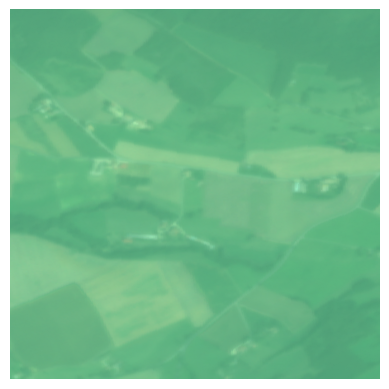

In [10]:
masks = []
for mask in output:
    masks.append(mask['segmentation'])

show_masks_on_image(image, masks)

Manual Method of Generating the Masks

In [11]:
def generate_bounding_boxes(image_width, image_height, box_size):
    stride = int(0.6 * box_size)
    num_boxes_horizontal = (image_width - box_size) // stride + 1
    num_boxes_vertical = (image_height - box_size) // stride + 1

    bounding_boxes = []
    for i in range(num_boxes_horizontal):
        for j in range(num_boxes_vertical):
            start_x = i * stride
            start_y = j * stride
            end_x = start_x + box_size
            end_y = start_y + box_size

            # Adjust for boxes extending beyond image boundaries
            end_x = min(end_x, image_width)
            end_y = min(end_y, image_height)

            bounding_boxes.append((start_x, start_y, end_x, end_y))

    return bounding_boxes

In [12]:
# bbox = generate_random_bounding_boxes(image.size[0], image.size[1], 50, image.size[0]/5, 0.25)
bbox = generate_bounding_boxes(image.size[0], image.size[1], int(image.size[0]*0.25))

In [13]:
# Image needs to be resized to 1024*1024 and necessary preprocessing should be done
# image = cv2.imread('4389.png')
scale_factor = 1024 / max(image.size[0], image.size[1])

sam_transform = ResizeLongestSide(model.image_encoder.img_size)
resize_img = sam_transform.apply_image(np.array(image))
resize_img = torch.as_tensor(resize_img.transpose(2, 0, 1)).to(device)
resize_img = model.preprocess(resize_img[None,:,:,:]) # (1, 3, 1024, 1024)

#scale the bbox prompts and point prompts according to the scale factor
bbox_prompts = np.around(np.array(bbox) * scale_factor)

bbox_prompts = torch.as_tensor(bbox_prompts).to(device)

In [14]:
with torch.no_grad():
    image_embeddings = model.image_encoder(resize_img)  # (B,256,64,64)
    #TODO: Store the image embeddings in torch cache for later use

    sparse_embeddings, dense_embeddings = model.prompt_encoder(
        points=None,
        boxes=bbox_prompts,
        masks=None,
    )

    low_res_masks, iou_predictions = model.mask_decoder(
        image_embeddings=image_embeddings.to(device),  # (B, 256, 64, 64)
        image_pe=model.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings,  # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings,  # (B, 256, 64, 64)
        multimask_output=False,
    )

In [15]:
upscaled_masks = model.postprocess_masks(low_res_masks, (1024, 1024), max(image.size[0], image.size[1])).to(device)
high_res_masks = normalize(threshold(upscaled_masks, 0.0, 0)).to(device).float()

In [16]:
high_res_masks

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        ...,


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1.

In [ ]:
#load the .npy file and print it 
training_loss = np.load('/home/aghosh57/Kerner-Lab/SAM-FineTuning/logs/Jun28_20-59-01/training_losses.npy')
training_loss

In [1]:
import cv2

In [ ]:
def _convert_polygons_to_pixels(parcel_geometry, polygon_labels, size):
        # Create a black background
        background = np.zeros(size, dtype=np.uint8)
         
        # Get the polygon bounds
        min_lon, min_lat, max_lon, max_lat = parcel_geometry.bounds
        
        # Get the width and height of the parcel
        height = max_lat - min_lat
        width = max_lon - min_lon

        # Get the pixel width and height
        pixel_height = size[0]/height
        pixel_width = size[1]/width

        pixel_masks = []
        for label in polygon_labels.geometry:
            pixel_mask = background.copy()
            # Iterate over the polygons in the multipolygon
            for polygon in label.geoms:
                coords = polygon.exterior.coords.xy

                # Get the pixel coords
                pixel_coords = []
                for i in range(len(coords[0])):
                    x = coords[0][i]
                    y = coords[1][i]

                    # Get the pixel x and y
                    pixel_x = (x - min_lon) * pixel_width
                    pixel_y = (max_lat - y) * pixel_height

                    pixel_coords.append([pixel_x, pixel_y])

                # Convert to int to make it work with cv2
                pixel_coords = np.array(pixel_coords, dtype=np.int32)
                # Fill the polygons and append to the pixel mask
                cv2.fillPoly(pixel_mask, pts=[pixel_coords], color=255)
            pixel_masks.append(pixel_mask.astype(dtype=bool))
        
        # Return the pixel masks as a numpy array
        return pixel_masks

In [ ]:
image_path = "/home/aghosh57/Kerner-Lab/all_dataset/0072.png"
mask_path = "/home/aghosh57/Kerner-Lab/all_dataset/0072.geojson"